<h1><center>Quantitative Input Influence</center></h1>
<h2><center> A study on influence of inputs on automated recidivism decisions</center></h2>
<center>Karina Huang, Lipika Ramaswamy  </center>
<center>AC221: Critical Thinking in Data Science </center>
<center>Spring 2019</center>

In [171]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from IPython.display import HTML


HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## I. Introduction

Responsible data science is necessary because of its impact on decision making. Consider the fairness of automated decision making in hiring and sentencing procedures. While fairness of algorithms remains debatable depending on how the term is defined, lack of interpretability in algorithms complicates the debate; if it remains unclear what contributes to a decision, it will be difficult to compartmentalize what makes the decision fair or unfair. Therefore, it is necessary that an algorithm be presented as clearly as possible. Granting algorithmic transparency helps facilitate discussions on the fairness of model design and consequences.

One approach to quantifying the interpretability of a model is the Quantitative Input Influence (QII) framework introduced by Datta et al. in their paper, *Algorithmic Transparency via Quantitative Input Influence*. These are causal measures that explain the influence of an input or a set of inputs on the decision made by machine learning algorithms. Transparency queries that use QII measures can be used to explain decisions about the classification outcome for an individual or a group. Specifically, for a quantity of infuence, *Q*, and an input feature, *i*, the QII of *i* on *Q* is the difference in *Q* when *i* is changed via intervention. In other words, we can replace features with random values from the population, and examine the distribution over outcomes for changes.

In this study, we examined the QII framework using the [COMPAS dataset](https://github.com/propublica/compas-analysis). ProPublica has previous published a [study](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm) presenting the scoring system as biased against African American individuals. Our objectives were to evaluate the validity of such claims by:

* examining the average importance of individual attributes on individual outcomes in modeling the COMPAS decile score categories (low, medium, high)
* comparing the QII outcomes on group disparity, with respect to the probability of being predicted in a decile score category
* investigating marginal influence of attributes on individuals in the dataset through transparency reports

## II. Data

ProPublica included 3 datasets on their Github page. Due to a lack of documentation regarding how the data was cleaned (we found discrepancies in the their reported methods and the actual dataset), we examined each of the dataset and chose to use the dataset in `compas-scores-two-years.csv`. Below we report the preliminary characteristics of the dataset.

In [185]:
#load data
data = pd.read_csv('../data/data_final.csv', index_col = ['Unnamed: 0'])
#check dataset
print('The size of this dataset is', data.shape, '; Note that the number of unique individuals is ', len(data.id.unique()))
print('Here is a snapshot of the first five rows of the dataset:')

data.head()

The size of this dataset is (7214, 15) ; Note that the number of unique individuals is  7214
Here is a snapshot of the first five rows of the dataset:


,id,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,decile_score,score_text,is_recid,v_decile_score,v_score_text,is_violent_recid,two_year_recid
0,1,Male,69,Other,0,0,0,0,1,Low,0,1,Low,0,0
1,3,Male,34,African-American,0,0,0,0,3,Low,1,1,Low,1,1
2,4,Male,24,African-American,0,0,1,4,4,Low,1,3,Low,0,1
3,5,Male,23,African-American,0,1,0,1,8,High,0,6,Medium,0,0
4,6,Male,43,Other,0,0,0,2,1,Low,0,1,Low,0,0


For each individual, there are decile scores and categories. We choose to explore the violent scores and categories. Note that scores of 1 to 4 correspond to 'Low', 5 to 7 correspond to 'Medium' and 8 to 10 correspond to 'High'.

We can see that the majority of records in the dataset correspond to a COMPAS score in the 'Low' category (66%), followed by 24% in the 'Medium' category, and 10% in the 'High' category.

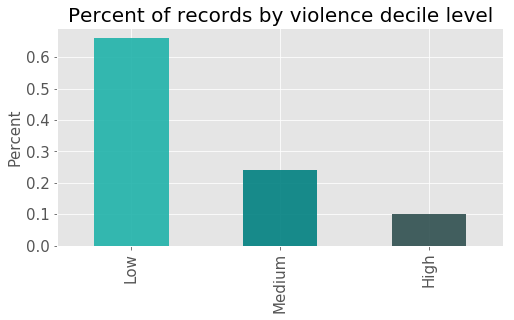

In [178]:
#plot counts by violence decile score categories 
plt.figure(figsize = (8,4))
data.v_score_text.value_counts(normalize=True).plot(kind = 'bar', color = ['lightseagreen','teal', 'darkslategrey' ], alpha = 0.9) ;
plt.ylabel('Percent',fontsize = 15); plt.yticks(fontsize = 15); plt.xticks(fontsize  = 15)
plt.title('Percent of records by violence decile level', fontsize = 20);

The visualizations below reveal the distribution of decile scores by race and sex. For all African-Americans in the dataset, the percent assigned to each COMPAS score is more uniform than is the case for most other groups. Of note is also the Native American group, of which a large percentage is assigned to medium to high violent decile scores. In comparison, roughly 40% of those in the Asian, Caucasian, Hispanic and Other groups are assigned to the lowest violent decile score.  
Similarly for gender, more females are assigned lower violent decile scores than males.

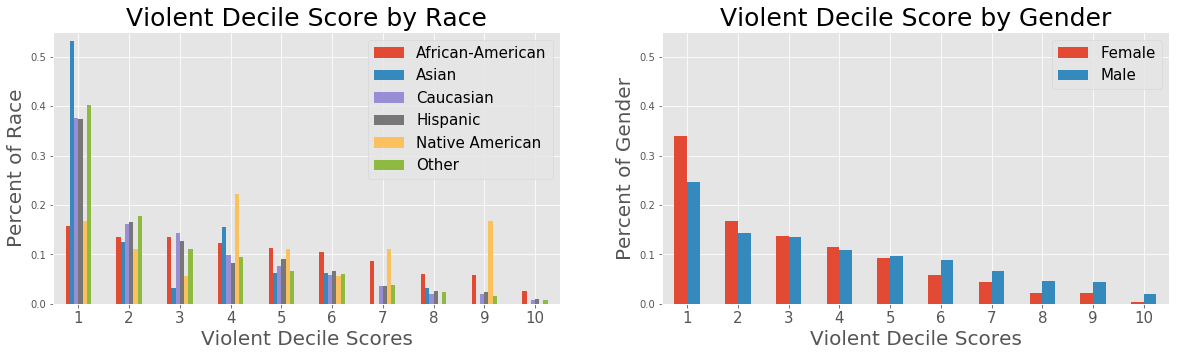

In [170]:
### VISUALIZATION
#violence decile score by race
violDR = data.groupby(['v_decile_score', 'race']).agg({'id': len}).unstack() ; violDR.columns = ['African-American','Asian', 'Caucasian', 'Hispanic','Native American', 'Other'] ; violDR = violDR.fillna(0)
for col in (violDR.columns):
    violDR[col] = violDR[col]/violDR[col].sum()
#violence decile score by sex
violDS = data.groupby(['v_decile_score', 'sex']).agg({'id': len}).unstack() ; violDS.columns = ['Female', 'Male']; 
for col in (violDS.columns):
    violDS[col] = violDS[col]/violDS[col].sum()
#visualize demographics
dfs = [violDR, violDS]
labels = ['Race', 'Gender']
fig, axes = plt.subplots(1, 2, figsize = (20, 5))
for i, ax in enumerate(axes.flat):
    dfs[i].plot(ax = ax, kind = 'bar')
    ax.set_xticklabels(labels = dfs[i].index, rotation = 0, fontsize = 15)
    ax.set_ylim(0,0.55)
    ax.set_xlabel('Violent Decile Scores', fontsize = 20)
    ax.set_ylabel('Percent of ' + labels[i], fontsize = 20)
    ax.legend(fontsize = 15)
    ax.set_title('Violent Decile Score by '+labels[i], fontsize = 25)
plt.show()

## III. Methodology

### Models

Using ProPublica's data, we model the violence decile categorization (low, medium, high) of an individual using their other attributes, including age, juvenile misdemeanor count, priors count, sex and race. The goal here is to reconstruct COMPAS assignments to violence decile categorization given that it is a blackbox algorithm. Effectively, we are trying to reconstruct a blackbox algorithm to use the framework described below. Note that we used violence decile categorization instead of numeric scores visualized above to closely mirror ProPublica's approach. Given the classification task at hand, we chose to employ Logistic Regression, a Support Vector Machine and a Decision Tree for this reconstruction.

### Quantitative Input Influence 
Given a black-box algorithm, $A$, we first define a quantity of interest, $Q$, which represents a property of the behavior of the algorithm for a given input distribution. $A$ operates on inputs or features, $i$, and every $i$ has a set of possible states it can take on, and $\mathbf{x}\in X$ is any vector representing a row the dataset that is drawn from the true *underlying* distribution represented by the random variable $X$. In the particular problem explored here, an example of an algorithm is Logistic Regression and an example of a feature is `race`, which can take on the following states: African-American, Caucasian, Hispanic, Asian, Native American and Other.

Formally, for a quantity of interest $Q_A(\cdot)$ and an input $i$, the Quantitative Input Influence of $i$ on $Q_A(\cdot)$ is defined as:
$$ \iota^{Q_A} = Q_A (X) - Q_A(X_{-i} U_i),$$
where the random variable $X_{-i}U_i$ represents the random variable with input $i$ replaced with a random sample, and represents the *intervened* distribution.

#### Unary QII
1. QII for individual outcomes:
    
    **One use of QII is to provide individuals with information on a particular classification outcome**. In order to quantify the use of an input for individual outcomes, we define the quantity of interest to be the classification outcome, $c$, for a particular individual, $\mathbf{x}$, given by $Q_{ind}^{\mathbf{x}} (\cdot) = \mathbb{E}(c(\cdot) = 1 | X = \mathbf{x})$. We can define the QII as: 
    $$ \iota^{\mathbf{x}}_{ind} =\mathbb{E}(c(X) = 1 | X = \mathbf{x}) - \mathbb{E}(c(X_{-i}U_i) = 1 | X = \mathbf{x})$$
    
   In our specific application, we are interested in the probability that a given feature is pivotal to the classification of an individual. We define this mathematically as:
   $$ \sum_{\mathbf{x}\in X}Pr(X=\mathbf{x}) \cdot \mathbb{E}(i\text{ is pivotal for }c(X)|X=\mathbf{x}) = \mathbb{E}(i\text{ is pivotal for }c(X))$$
    
2. QII for group disparity:

    **QII on group disparity denotes the association between classification outcomes and membership in a group.** In this case, the quantity of interest is the absolute difference of postive classification outcomes between a given group and all others.
    $$Q_{disp}^\mathcal{Y} (\cdot)  = | \mathbb{E}(c(\cdot) = 1 | X \in \mathcal{Y}) -  \mathbb{E}(c(\cdot) = 1 | X \notin \mathcal{Y})|$$
    
    We can thus define the QII as: 
    $$\iota_{disp}^{\mathcal{Y}}(i) = Q_{disp}^{\mathcal{Y}} (X) - Q_{disp}^{\mathcal{Y}} (X_{-i}U_i)$$
    
 
#### Set and Marginal QII

In the overwhelming majority of real datasets, it is impossible to look at the *individual* influence of one feature on an outcome, as it is likely correlated with other features that were included in the decision making process. Thus, if we intervene on only one feature, changes to the outcome will be less likely, as the features correlated with it will still capture some of the feature in question's impact. So if we intervene on sets of features including a given feature, we may get a better understanding of the influence of this feature by looking at its marginal influence.

For a quantity of interest, $Q$, and an input $i$, the QII of input $i$ over a set $S\subseteq N$ on $Q$ is defined to be

$$\iota^Q(i,S) = Q(X_{-S}U_{S}) - Q(X_{-S\cup\{i\}}U_{S\cup\{i\}})$$ 

It is clear from the equation that the marginal QII of $i$ is the additional value in transparency achieved by including $i$ in a subset of features.

The marginal contribution of $i$ can vary depending on which set $S$ is considered, so we report the aggregate marginal contribution of $i$ to $S$, where S is sampled from some distribution over subsets of features. We use the Shapley value as a measure of this aggregate marginal contribution. This is what we present in transparency reports for an individual.

## IV. Evaluation and Results

## V. Future Work

#### Improve classifier performance
This problem has been tackled using classifiers that have been minimally tuned. We recognize that the best classification accuracy achieved by any of our models on out-of-sample predictions is 76.3% (SVM), which clearly falls short of perfectly predicting COMPAS scores. Had our goal been to predict COMPAS scores accurately, we would have balanced classes using some synthetic oversampling technique. Further, hyperparameter tuning could also be done to try for better model performance.

#### Differentially private releases
Given their construction, transparency reports can reveal sensitive information about the all data used to train the decision aiding classifier. We recommend making either the classifiers themselves differentially private (see [Abadi et al.](https://arxiv.org/pdf/1607.00133.pdf)) or making the release of transparency reports differentially private by addition of noise. Note that these procedures are computationally expensive for large data, so we leave it as an extension to our QII work.

___